In [2]:
from IPython.core.display import display, HTML
display(HTML(
    '<style>'
        '#notebook { padding-top:0px !important; } ' 
        '.container { width:100% !important; } '
        '.end_space { min-height:0px !important; } '
    '</style>'
))

In [29]:
from habitat.sims.habitat_simulator.actions import HabitatSimActions

from habitat_dataset import get_dataset, HabitatDataset

from pathlib import Path
import torch
import torch.nn as nn
from resnet import ResnetBase
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
import pandas as pd
import cv2

ACTIONS = {v: k for k, v in HabitatSimActions._known_actions.items()}

transform  = transforms.ToTensor()
transform_ = transforms.ToPILImage()
dataset = HabitatDataset('data/depth/train/000002', apply_transform=False)

i = 20
rgb, _, _, action, meta, _ = dataset[i]

In [7]:
def spatial_softmax_base():
    return nn.Sequential(
            nn.BatchNorm2d(512),
            nn.ConvTranspose2d(512, 256, 3, 2, 1, 1),
            nn.ReLU(True),
            nn.BatchNorm2d(256),
            nn.ConvTranspose2d(256, 128, 3, 2, 1, 1),
            nn.ReLU(True),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128, 64, 3, 2, 1, 1),
            nn.ReLU(True)
    )

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

# Direct Imitation `[v2.x]`
Should at least work for not crashing/getting stuck... Might need to do DAgger or something to capture non-perfect situations.

In [8]:
class DirectImitation(ResnetBase): # v2.x
    def __init__(self, resnet_model='resnet34', **resnet_kwargs):
        resnet_kwargs['input_channel'] = resnet_kwargs.get('input_channel', 3)

        super().__init__(resnet_model, **resnet_kwargs)

        self.normalize = nn.BatchNorm2d(resnet_kwargs['input_channel'])
        self.deconv = spatial_softmax_base()
        self.extract = nn.Sequential(
                nn.BatchNorm2d(64),
                nn.Conv2d(64, 5, 1, 1, 0))#,
                #common.SpatialSoftmax(temperature))
      
        self.fc1 = nn.Linear(64, 1)
        self.fc2 = nn.Linear(64, 1)
 
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        rgb = x[0]

        rgb = self.normalize(rgb)
        rgb = self.conv(rgb)
        rgb = self.deconv(rgb)
        _x = self.extract(rgb)
        print(_x.shape)

        return self.softmax(self.fc2(self.fc1(_x).squeeze()).squeeze())

In [7]:
net = DirectImitation()

net((rgb.unsqueeze(dim=0),)).detach()

torch.Size([1, 5, 64, 64])


tensor([0.2002, 0.2241, 0.1861, 0.1798, 0.2099])

# Direct (DD-PPO setup) `[4.x]`
* SE-ResNeXt-50
* GroupNorm
* normalize RGB channels

In [24]:
from habitat_baselines.rl.ddppo.policy.resnet_policy import ResNetEncoder
from habitat_baselines.rl.ddppo.policy import resnet
from habitat_baselines.common.utils import CategoricalNet
from gym import spaces

class DirectImitationDDPPO(nn.Module): # v4.x
    def __init__(self, resnet_model='se_resneXt50', baseplanes=32, ngroups=16, hidden_size=512, dim_actions=4):
        super().__init__()
        
        self.visual_encoder = ResNetEncoder(
            spaces.Dict({'rgb': spaces.Box(low=0, high=255, shape=(256, 256, 3), dtype='uint8')}),
            baseplanes=baseplanes,
            ngroups=ngroups,
            make_backbone=getattr(resnet, resnet_model),
            normalize_visual_inputs=True
        )
        
        self.visual_fc = nn.Sequential(
            Flatten(),
            nn.Linear(np.prod(self.visual_encoder.output_shape), hidden_size),
            nn.ReLU(True)
        )

        self.action_distribution = CategoricalNet(hidden_size, dim_actions)

    def forward(self, x):
        rgb = x[0]
        rgb_vec = self.visual_encoder({'rgb': rgb})

        return self.action_distribution(self.visual_fc(rgb_vec)).logits

net = DirectImitationDDPPO()

In [41]:
net = DirectImitationDDPPO(resnet_model='resnet50')

_rgb = torch.Tensor(np.uint8(rgb)).unsqueeze(dim=0)
net((_rgb.reshape(1,256,256,3),))[0].argmax().item()

2

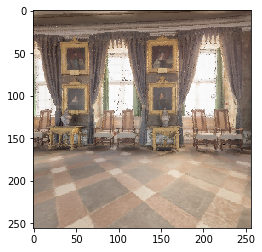

In [39]:
plt.imshow(np.uint8(rgb))

# Direct + DAgger (DD-PPO setup) `[5.x]`

# Conditional Imitation `[v3.x]`

Let's try conditioning on:
* **zero-centered delta vector** (DD-PPO fig3)

In [20]:
class ConditionalImitation(ResnetBase): # 3.x
    def __init__(self, resnet_model='resnet34', **resnet_kwargs):
        resnet_kwargs['input_channel'] = resnet_kwargs.get('input_channel', 3)

        super().__init__(resnet_model, **resnet_kwargs)

        self.normalize = nn.BatchNorm2d(resnet_kwargs['input_channel'])
        self.deconv = spatial_softmax_base()
        self.extract = nn.Sequential(
                nn.BatchNorm2d(64),
                nn.Conv2d(64, 5, 1, 1, 0))

        self.fc1 = nn.Linear(64, 1)
        self.fc2 = nn.Linear(64, 2)
        self.fc3 = nn.Linear(10, 5)

        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        rgb, meta = x

        rgb = self.normalize(rgb)
        rgb = self.conv(rgb)
        rgb = self.deconv(rgb)
        rgb = self.extract(rgb)
        rgb = self.fc1(rgb).squeeze()
        rgb = self.fc2(rgb)
        x = self.fc3(rgb.view((-1, 10)) + meta)

        return self.softmax(x)

In [23]:
net = ConditionalImitation()

net((rgb.unsqueeze(dim=0), meta)).detach()

tensor([[0.5246, 0.3132, 0.0072, 0.1155, 0.0395]])

---

In [10]:
for rgb, _, _, action, _ in dataset:
    img = np.array(transform_(rgb))

    cv2.putText(img, 'Predicted: {}'.format(ACTIONS[(net(rgb.unsqueeze(dim=0)).detach()).argmax().item()]),
        (10, 20),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.5,
        (255,255,255),
        2)

    cv2.putText(img, 'Actual:    {}'.format(ACTIONS[action.argmax().item()]),
        (10, 40),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.5,
        (255,255,255),
        2)

    cv2.imshow('rgb', img)
    cv2.waitKey(1)